In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

# Read data
df = pd.read_csv("uber_4weeks.csv")

# filter data by location id
df_loc1 = df[df['locationID']==1]

# drop columns id, timestamp, locationID
df_loc1 = df_loc1.drop(['id','timestamp','locationID'],axis=1)

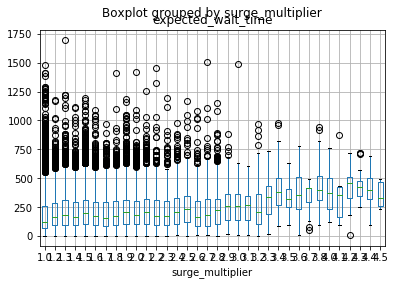

In [3]:
# draw boxplot of expected_wait_time by surge_multiplier
df_loc1.boxplot(column="expected_wait_time",by="surge_multiplier")

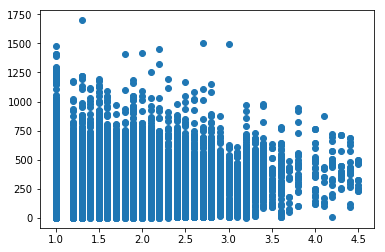

In [6]:
# plot expected_wait_time over surge_multiplier
plt.scatter(df_loc1['surge_multiplier'],df_loc1['expected_wait_time'])

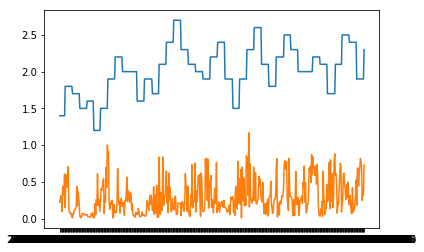

In [10]:
# load data again and filter data by location id
df_loc1 = df[df['locationID']==1]

# plot surge_multiplier over time
plt.plot(df_loc1['timestamp'].head(500),df_loc1['surge_multiplier'].head(500))

# plot ETA over time
plt.plot(df_loc1['timestamp'].head(500),df_loc1['expected_wait_time'].head(500)/np.max(df_loc1['expected_wait_time'].head(200)))

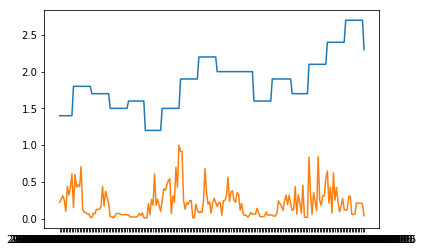

In [45]:
# load data again and filter data by location id
df_loc1 = df[df['locationID']==1]

# plot surge_multiplier over time
plt.plot(df_loc1['timestamp'].iloc[0:200],df_loc1['surge_multiplier'].iloc[0:200])

# plot ETA over time
plt.plot(df_loc1['timestamp'].iloc[0:200],df_loc1['expected_wait_time'].iloc[0:200]/np.max(df_loc1['expected_wait_time'].iloc[0:200]))

In [141]:
ETAROL = df_loc1['expected_wait_time'].rolling(12).mean()

df_loc1['ETArol'] = ETAROL.values

/Users/tigranbagramyan/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


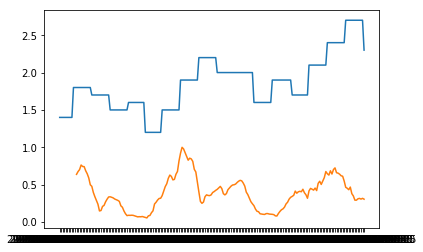

In [144]:
# plot surge_multiplier over time
plt.plot(df_loc1['timestamp'].iloc[0:200],df_loc1['surge_multiplier'].iloc[0:200])

# plot ETA over time
plt.plot(df_loc1['timestamp'].iloc[0:200],df_loc1['ETArol'].iloc[0:200]/np.max(df_loc1['ETArol'].iloc[0:200]))

/Users/tigranbagramyan/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  
/Users/tigranbagramyan/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  if __name__ == '__main__':


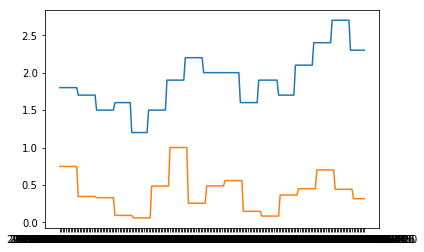

In [134]:
# delete first rowas to adjust to surge mulitplier update period (3 min = 12 rows)
df_new = df_loc1.drop(df.index[[0,7,12,17,21,28,31,36,40]])

# make timestamp an index
df_new.index = pd.to_datetime(df_new['timestamp'])

# resample ETA and multiplier in 3min intervals calculating mean value inside each interval
y1 = df_new.expected_wait_time.resample('3min', how='mean') # resampled ETA
y2 = df_new.surge_multiplier.resample('3min', how='mean') # resampled surge multiplier

# add a column with mean expected wait time y2 to the dataframe
wait_time_mean = []
i = -1
j = -1
for index, row in df_new.iterrows():
    i += 1
    if i%12==0:
        j += 1
    wait_time_mean.append(y1[j])    
    
df_new['wait_time_mean'] = wait_time_mean

#draw surge multiplier and mean ETA for every 3 min period
plt.plot(df_new['timestamp'].head(200),df_new['surge_multiplier'].head(200))
plt.plot(df_new['timestamp'].head(200),df_new['wait_time_mean'].head(200)/np.max(df_new['wait_time_mean'].head(200)))


In [199]:
# get lag with cross-rorrelation
from scipy.signal import correlate
from scipy.stats import zscore

y2 = y2[~np.isnan(y2)]
y1 = y1[~np.isnan(y1)]

a_sig = y2#df_new['surge_multiplier'].head(200).values
b_sig = y1#df_new['wait_time_mean'].head(200).values

difa = np.diff(a_sig)
difaN = zscore(difa)
difb = np.diff(b_sig)
difbN = zscore(difb)

#lag = np.argmax(correlate(a_sig, b_sig,mode='same'))
#c_sig = np.roll(b_sig, shift=int(np.ceil(lag)))
#lag = np.argmax(correlate(difa[0:20], difb[0:20],mode='same'))
difbNrol = np.roll(difbN, shift=int(1))

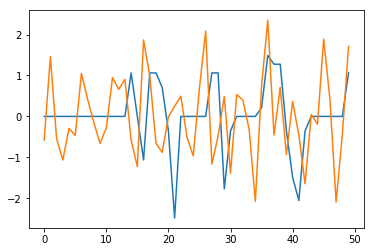

In [200]:
plt.plot(difaN[500:550])
#plt.plot(difb[0:20])
plt.plot(difbNrol[500:550])

In [201]:
from scipy.stats import pearsonr

pearsonr(difaN,difbNrol)

(0.30114011288430725, 1.0500815637746809e-279)

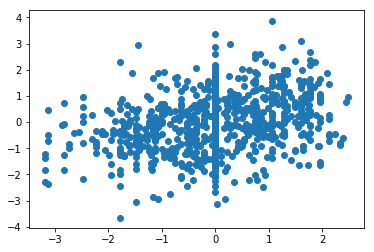

In [202]:
plt.scatter(difaN[0:1000],difbNrol[0:1000])

Coefficients: 
 [[0.29082274]]
Mean squared error: 1.15
Variance score: 0.11


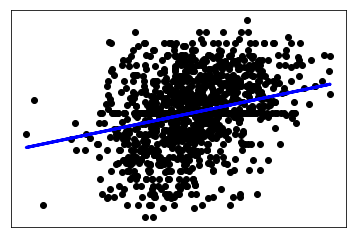

In [219]:
# fit linear regression
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

# Split the data into training/testing sets
difbN_train = difbNrol[:12000]
difbN_test = difbNrol[12000:]

# Split the targets into training/testing sets
difaN_train = difaN[:12000]
difaN_test = difaN[12000:]

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(difbN_train[:,np.newaxis], difaN_train[:,np.newaxis])

# Make predictions using the testing set
difaN_pred = regr.predict(difbN_test[:,np.newaxis])

# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(difaN_test, difaN_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(difaN_test, difaN_pred))

# Plot outputs
plt.scatter(difbN_test, difaN_test,  color='black')
plt.plot(difbN_test, difaN_pred, color='blue', linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

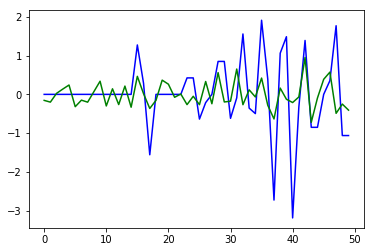

In [220]:
#plt.plot(difaN_test[0:50],color='yellow')
plt.plot(difaN_test[0:50],color='blue')
plt.plot(difaN_pred[0:50],color='green')

Mean squared error: 1.55
Variance score: -0.21


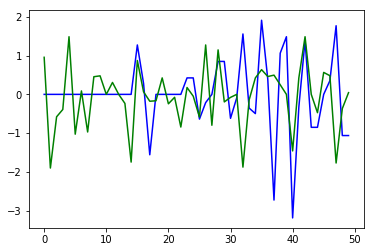

In [221]:
# fit decision tree
from sklearn import tree

# Split the data into training/testing sets
difbN_train = difbNrol[:12000]
difbN_test = difbNrol[12000:]

# Split the targets into training/testing sets
difaN_train = difaN[:12000]
difaN_test = difaN[12000:]

clf = tree.DecisionTreeRegressor()
clf = clf.fit(difbN_train[:,np.newaxis], difaN_train[:,np.newaxis])

difaN_pred = clf.predict(difbN_test[:,np.newaxis])

# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(difaN_test, difaN_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(difaN_test, difaN_pred))

#plt.plot(difaN_test[0:50],color='yellow')
plt.plot(difaN_test[0:50],color='blue')
plt.plot(difaN_pred[0:50],color='green')

/Users/tigranbagramyan/anaconda/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:1306: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean squared error: 1.14
Variance score: 0.11


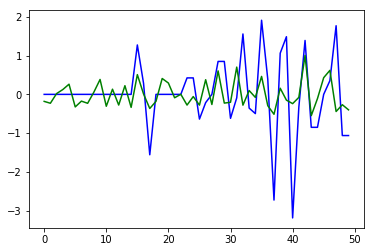

In [235]:
# train polynomial regression
from sklearn.neural_network import MLPRegressor

# Split the data into training/testing sets
difbN_train = difbNrol[:12000]
difbN_test = difbNrol[12000:]

# Split the targets into training/testing sets
difaN_train = difaN[:12000]
difaN_test = difaN[12000:]

#clf = MLPRegressor(alpha=0.001,hidden_layer_sizes = (100,25,11))
clf = MLPRegressor()
clf = clf.fit(difbN_train[:,np.newaxis], difaN_train[:,np.newaxis])

difaN_pred = clf.predict(difbN_test[:,np.newaxis])

# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(difaN_test, difaN_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(difaN_test, difaN_pred))

#plt.plot(difaN_test[0:50],color='yellow')
plt.plot(difaN_test[0:50],color='blue')
plt.plot(difaN_pred[0:50],color='green')

In [82]:
df_resized = pd.DataFrame(y2)
df_resized['expected_wait_time'] = y1.values

In [83]:
df_resized.head()

,surge_multiplier,expected_wait_time
timestamp,,
2015-03-15 00:00:00,1.800,185.000000
2015-03-15 00:03:00,1.775,85.833333
2015-03-15 00:06:00,1.650,81.666667
2015-03-15 00:09:00,1.525,23.083333
2015-03-15 00:12:00,1.520,14.800000


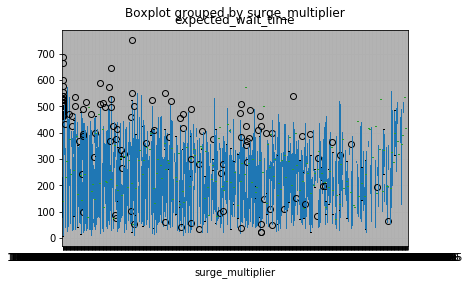

In [85]:
df_resized.boxplot(column="expected_wait_time",by="surge_multiplier")